In [128]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [129]:
# pickle에서 데이터프레임 다시 불러오기
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [130]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt_train = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [131]:
extra_data_path = '../yoon/extra_data/'

In [132]:
print(extra_data_path)
os.getcwd()


../yoon/extra_data/


'/root/upstage-ml-regression-3/Sh'

In [133]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [134]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [135]:
dt = dt.reset_index()

In [136]:
df['동'] = dt['동']

### 년도에따라 동, 구별 statistics 추가

<Axes: xlabel='target', ylabel='Density'>

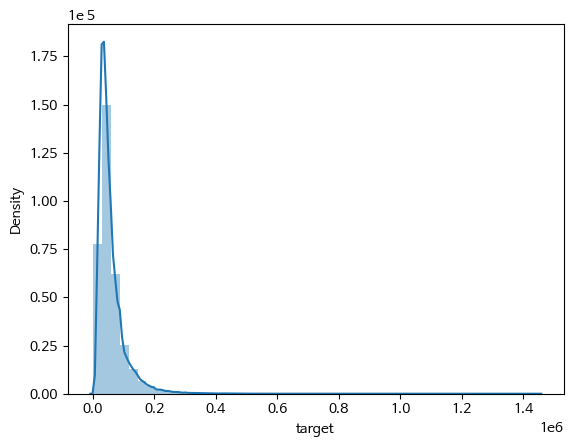

In [137]:
# df.drop(['아파트명'], axis=1, inplace=True)
sns.distplot(df.loc[:,'target'])

In [138]:
#아파트명 csv로 보기.
# s_df = df[df.target>=270000]
# apt= s_df['아파트명'].value_counts()
# apt

# apt2 = pd.DataFrame({'아파트명': apt.index, 'num':apt.values})



# apt2.to_csv('apt2.csv', index=False)

<Axes: xlabel='target', ylabel='Density'>

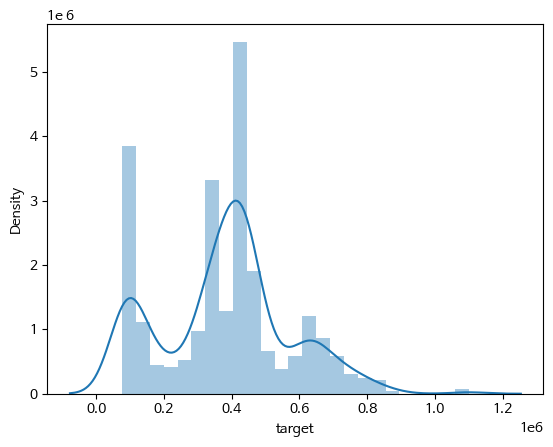

In [139]:
#문제의 한남 더 힐 분포 보기

hn = df[df['아파트명']=='한남더힐']

sns.distplot(hn.loc[:,'target'])



In [140]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [141]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약년,계약월,평균공시가격,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,2017,12,120960.0,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [142]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [143]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [144]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [145]:
df.drop(['아파트명','구', 'large_std_동', 'date', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

In [146]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '계약년',
       '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max'],
      dtype='object')

In [147]:
df['건축년도'].dtype

dtype('int64')

In [148]:
df['계약년월'].dtype

dtype('int64')

In [149]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [150]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '계약년',
       '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [151]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")


# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [152]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [153]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [154]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '계약년',
       '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [155]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [156]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [157]:
df.drop(columns=['date', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [158]:
df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [159]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '계약년',
       '계약월', '평균공시가격', '계약일', '동', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff', 'Close_delay120d'],
      dtype='object')

In [160]:
df.drop(columns=['계약년', '계약월', '계약일'], inplace=True)

In [161]:
df = df[df['계약년월']>=201501]
df.sort_values(by='계약년월')

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
701077,336,84.87,201501,14,2003,장안벚꽃로 107,43300.0,0,47463.663220,장안동,9339.081397,38387.940039,75900.0,12,2006.905000
720907,1500,59.95,201501,12,2001,독서당로 343,40600.0,0,71502.749141,금호동1가,7498.316902,44702.148760,62000.0,14,2026.620000
720908,1500,59.95,201501,8,2001,독서당로 343,40000.0,0,71502.749141,금호동1가,7498.316902,44702.148760,62000.0,14,2048.810000
668322,1158,84.97,201501,8,2006,우현로 26,41000.0,0,48647.290640,화곡동,18485.524203,39325.281856,90198.0,9,2031.555000
668321,1158,84.97,201501,4,2006,우현로 26,41300.0,0,48647.290640,화곡동,18485.524203,39325.281856,90198.0,9,2021.203333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121532,1002-1,41.22,202309,7,1981,시흥대로47길 43,NaN,1,37601.724138,시흥동,18739.666871,54811.864407,102500.0,42,2395.690000
1121524,1013,59.34,202309,19,2004,금하로 816,NaN,1,34454.448399,시흥동,18739.666871,54811.864407,102500.0,19,2404.853333
1121523,1013,84.97,202309,19,2004,금하로 816,NaN,1,34454.448399,시흥동,18739.666871,54811.864407,102500.0,19,2392.026667
1125986,163-14,59.91,202309,1,1997,오금로32길 42,NaN,1,64433.744856,송파동,27461.131123,135602.941176,210000.0,26,2405.486667


In [162]:
# 값이 너무 저렴한 아파트 삭제함. ph129는 그냥 삭제함 너무 비쌈.
# 아크로서울포레스트 = 233420, 276043,
# 르가든더메인한남 = 236651,
# 상지리츠빌카일룸3차 = 394194,
# 이그나빌 = 203593,
# 이그나빌2 = 394206,
# 로덴하우스이스트빌리지 = 296155,
# PH129 =224566, 224567, 241238, 241239


drop_apt = [233420, 276043, 236651, 394194, 203593, 394206,  296155,224566, 224567, 241238, 241239]

df = df.drop(index = drop_apt)
df

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d
0,658-1,79.97,201712,3,1987,언주로 3,124000.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2372.640000
1,658-1,79.97,201712,4,1987,언주로 3,123500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2382.560000
2,658-1,54.98,201712,5,1987,언주로 3,91500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2394.480000
3,658-1,79.97,201801,4,1987,언주로 3,130000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2388.350000
4,658-1,79.97,201801,2,1987,언주로 3,117000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2382.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,202307,13,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2428.570000
1128090,816,84.62,202307,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2425.080000
1128091,816,101.65,202308,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2420.253333
1128092,816,84.94,202309,18,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2415.426667


In [163]:
exp_dong = ['반포동','한남동','청담동','압구정동','삼성동','도곡동','성수동1가']

In [164]:
df['exp'] = df['동'].isin(exp_dong)*1

df['m135'] = (df['전용면적(㎡)']>=135) *1

df['exp2'] = df['exp']+df['m135']
df

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d,exp,m135,exp2
0,658-1,79.97,201712,3,1987,언주로 3,124000.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2372.640000,0,0,0
1,658-1,79.97,201712,4,1987,언주로 3,123500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2382.560000,0,0,0
2,658-1,54.98,201712,5,1987,언주로 3,91500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2394.480000,0,0,0
3,658-1,79.97,201801,4,1987,언주로 3,130000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2388.350000,0,0,0
4,658-1,79.97,201801,2,1987,언주로 3,117000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2382.100000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,202307,13,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2428.570000,0,0,0
1128090,816,84.62,202307,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2425.080000,0,0,0
1128091,816,101.65,202308,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2420.253333,0,0,0
1128092,816,84.94,202309,18,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2415.426667,0,0,0


In [165]:
df = df.drop(columns=['exp','m135'])
df

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d,exp2
0,658-1,79.97,201712,3,1987,언주로 3,124000.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2372.640000,0
1,658-1,79.97,201712,4,1987,언주로 3,123500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2382.560000,0
2,658-1,54.98,201712,5,1987,언주로 3,91500.0,0,120960.000000,개포동,32126.755612,108070.249556,260000.0,30,2394.480000,0
3,658-1,79.97,201801,4,1987,언주로 3,130000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2388.350000,0
4,658-1,79.97,201801,2,1987,언주로 3,117000.0,0,120960.000000,개포동,43598.058342,142378.337531,260000.0,31,2382.100000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,202307,13,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2428.570000,0
1128090,816,84.62,202307,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2425.080000,0
1128091,816,101.65,202308,12,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2420.253333,0
1128092,816,84.94,202309,18,2014,신내역로1길 85,NaN,1,39021.326676,신내동,11341.218441,54184.649123,85000.0,9,2415.426667,0


In [166]:
df[df['exp2']==2]

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,Close_delay120d,exp2
542,527,176.9924,201712,17,2006,선릉로 221,240000.0,0,194236.642239,도곡동,51482.392380,135377.500000,492000.0,11,2361.830000,2
622,527,138.3156,201808,4,2006,선릉로 221,260000.0,0,194236.642239,도곡동,64740.609694,162540.491311,500000.0,12,2402.476667,2
654,933,142.7700,201711,1,1978,남부순환로363길 30,143000.0,0,143337.500000,도곡동,51482.392380,135377.500000,492000.0,39,2394.966667,2
659,933,142.7700,201801,6,1978,남부순환로363길 30,149000.0,0,143337.500000,도곡동,64740.609694,162540.491311,500000.0,40,2429.940000,2
661,933,142.7700,201801,6,1978,남부순환로363길 30,158000.0,0,143337.500000,도곡동,64740.609694,162540.491311,500000.0,40,2439.900000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127412,386,237.5200,202307,3,2019,한남대로10길 16,NaN,1,429625.000000,한남동,279436.203653,334323.529412,1100000.0,4,2359.530000,2
1127413,386,239.6700,202307,4,2019,한남대로10길 16,NaN,1,429625.000000,한남동,279436.203653,334323.529412,1100000.0,4,2484.020000,2
1127415,410,268.6700,202308,4,2020,유엔빌리지길 80-36,NaN,1,785864.705882,한남동,279436.203653,334323.529412,1100000.0,3,2417.680000,2
1127417,805,203.7600,202308,15,2002,서빙고로 413,NaN,1,236636.885246,한남동,279436.203653,334323.529412,1100000.0,21,2439.090000,2


### Feature Engineering

### Train

In [167]:
# is_20000 = True

In [168]:
# if is_20000:
#     df['계약년월']= df['계약년월'] - 200000
#     is_20000 = False
# df

In [169]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(636725, 15) (9272, 15)


In [170]:
# 2015년 이후로 나누기.
# close_delay 제거
# 계약 년월 빼버리기.

df_train = df_train[df_train['계약년월']>=201501]
df_train = df_train.drop(columns='Close_delay120d')

# df_train = df_train.drop(columns='계약년월')
df_train.exp2.unique()


array([0, 1, 2])

In [171]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff', 'exp2']
범주형 변수: ['번지', '도로명', '동']


In [172]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


In [173]:




df_train0 = df_train[df_train['exp2']!=2]

df_train_exp = df_train[(df_train['exp2']==2)]


In [174]:
df_train_exp

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,exp2
542,4059,176.9924,201712,17,2006,4866,240000.0,194236.642239,62,51482.392380,135377.500000,492000.0,11,2
622,4059,138.3156,201808,4,2006,4866,260000.0,194236.642239,62,64740.609694,162540.491311,500000.0,12,2
654,6238,142.7700,201711,1,1978,1598,143000.0,143337.500000,62,51482.392380,135377.500000,492000.0,39,2
659,6238,142.7700,201801,6,1978,1598,149000.0,143337.500000,62,64740.609694,162540.491311,500000.0,40,2
661,6238,142.7700,201801,6,1978,1598,158000.0,143337.500000,62,64740.609694,162540.491311,500000.0,40,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807664,1292,155.3800,201505,18,2012,5489,188000.0,227025.692695,111,61736.026445,138614.054126,360000.0,3,2
807669,1292,155.3800,201506,3,2012,5489,184000.0,227025.692695,111,61736.026445,138614.054126,360000.0,3,2
807674,1292,155.9500,201508,19,2012,5489,204000.0,227025.692695,111,61736.026445,138614.054126,360000.0,3,2
807676,1292,155.9500,201509,4,2012,5489,188000.0,227025.692695,111,61736.026445,138614.054126,360000.0,3,2


In [175]:
df_train.target.describe().round(2)

count     636725.00
mean       68549.11
std        52802.73
min          700.00
25%        36900.00
50%        53800.00
75%        82800.00
max      1350000.00
Name: target, dtype: float64

In [176]:
y_train0 = df_train0['target']
X_train0 = df_train0.drop(['target'], axis=1)


y_train_exp = df_train_exp['target']
X_train_exp = df_train_exp.drop(['target'], axis=1)



# Split the data into train and validation sets
X_train0, X_val0, y_train0, y_val0 = train_test_split(X_train0, y_train0, test_size=0.2, random_state=2023)
X_train_exp, X_val_exp, y_train_exp, y_val_exp = train_test_split(X_train_exp, y_train_exp, test_size=0.001, random_state=2023)


In [177]:
gbm0 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)



gbm_exp = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=10,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)




In [178]:
gbm0.fit(
        X_train0, y_train0, 
        eval_set=[(X_train0, y_train0), (X_val0, y_val0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5011.43	training's l2: 2.51144e+07	valid_1's rmse: 5919.85	valid_1's l2: 3.50446e+07
[200]	training's rmse: 4198.02	training's l2: 1.76233e+07	valid_1's rmse: 5451.22	valid_1's l2: 2.97158e+07
[300]	training's rmse: 3815.74	training's l2: 1.45599e+07	valid_1's rmse: 5311.15	valid_1's l2: 2.82083e+07
[400]	training's rmse: 3556.93	training's l2: 1.26517e+07	valid_1's rmse: 5231.26	valid_1's l2: 2.73661e+07
[500]	training's rmse: 3361.86	training's l2: 1.13021e+07	valid_1's rmse: 5185.78	valid_1's l2: 2.68923e+07
[600]	training's rmse: 3196.91	training's l2: 1.02203e+07	valid_1's rmse: 5163.82	valid_1's l2: 2.6665e+07
[700]	training's rmse: 3065.7	training's l2: 9.3985e+06	valid_1's rmse: 5145.7	valid_1's l2: 2.64782e+07
[800]	training's rmse: 2945.6	training's l2: 8.67654e+06	valid_1's rmse: 5134.59	valid_1's l2: 2.6364e+07
[900]	training's rmse: 2841.83	training's l2: 8.07602e+06	valid_1's rmse: 5128.36

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=50, n_estimators=5000, num_leaves=600,
              verbosity=-1)

In [179]:
gbm_exp.fit(
        X_train_exp, y_train_exp, 
        eval_set=[(X_train_exp, y_train_exp), (X_val_exp, y_val_exp)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9135.16	training's l2: 8.34511e+07	valid_1's rmse: 25570.8	valid_1's l2: 6.53865e+08
Early stopping, best iteration is:
[117]	training's rmse: 8152.38	training's l2: 6.64612e+07	valid_1's rmse: 25444.2	valid_1's l2: 6.47407e+08


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=10, n_estimators=5000, num_leaves=600,
              verbosity=-1)

In [180]:
X_test = df_test.drop(['target'], axis=1)
X_test = X_test.drop(columns='Close_delay120d')
# X_test = X_test.drop(columns='계약년월')

X_test

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,exp2
1118822,4682,79.9700,202307,5,1987,6024,120960.000000,8,65335.877082,169735.593220,370000.0,36,0
1118823,4657,108.2017,202308,10,2021,464,155775.000000,8,65335.877082,169735.593220,370000.0,2,0
1118824,4658,161.0000,202307,15,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,1
1118825,4658,133.4600,202308,14,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,0
1118826,4658,104.4300,202308,6,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,84.6500,202307,13,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0
1128090,5716,84.6200,202307,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0
1128091,5716,101.6500,202308,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0
1128092,5716,84.9400,202309,18,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0


In [181]:
X_test0 = X_test[(X_test['exp2']!=2)]
X_test_exp = X_test[X_test['exp2']==2]


In [182]:
real_test_pred0 = gbm0.predict(X_test0)
real_test_pred_exp = gbm_exp.predict(X_test_exp)



In [183]:
X_test0['target'] = real_test_pred0
X_test_exp['target'] = real_test_pred_exp



In [184]:
# concat

concat_test = pd.concat([X_test0, X_test_exp], axis=0)
concat_test = concat_test.sort_index()
concat_test


,번지,전용면적(㎡),계약년월,층,건축년도,도로명,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,exp2,target
1118822,4682,79.9700,202307,5,1987,6024,120960.000000,8,65335.877082,169735.593220,370000.0,36,0,193610.328186
1118823,4657,108.2017,202308,10,2021,464,155775.000000,8,65335.877082,169735.593220,370000.0,2,0,262267.698524
1118824,4658,161.0000,202307,15,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,1,275190.599043
1118825,4658,133.4600,202308,14,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,0,250270.038583
1118826,4658,104.4300,202308,6,1984,462,182537.777778,8,65335.877082,169735.593220,370000.0,39,0,203779.777291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,84.6500,202307,13,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0,72026.872712
1128090,5716,84.6200,202307,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0,72211.536897
1128091,5716,101.6500,202308,12,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0,85608.149119
1128092,5716,84.9400,202309,18,2014,5423,39021.326676,173,11341.218441,54184.649123,85000.0,9,0,69462.562682


In [185]:

# X_test에서 target만 분리.

ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('gu-dong-encoded_fire11.csv', index=False)



In [186]:
# real_test_pred = gbm.predict(X_test)
# preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
# preds_df.to_csv('gu-dong-encoded_6pm.csv', index=False)

In [187]:
preds_df2.target.describe().round(2)

count       9272.00
mean      108061.49
std        76242.42
min         7748.00
25%        63042.50
50%        88269.00
75%       128521.25
max      1267351.00
Name: target, dtype: float64

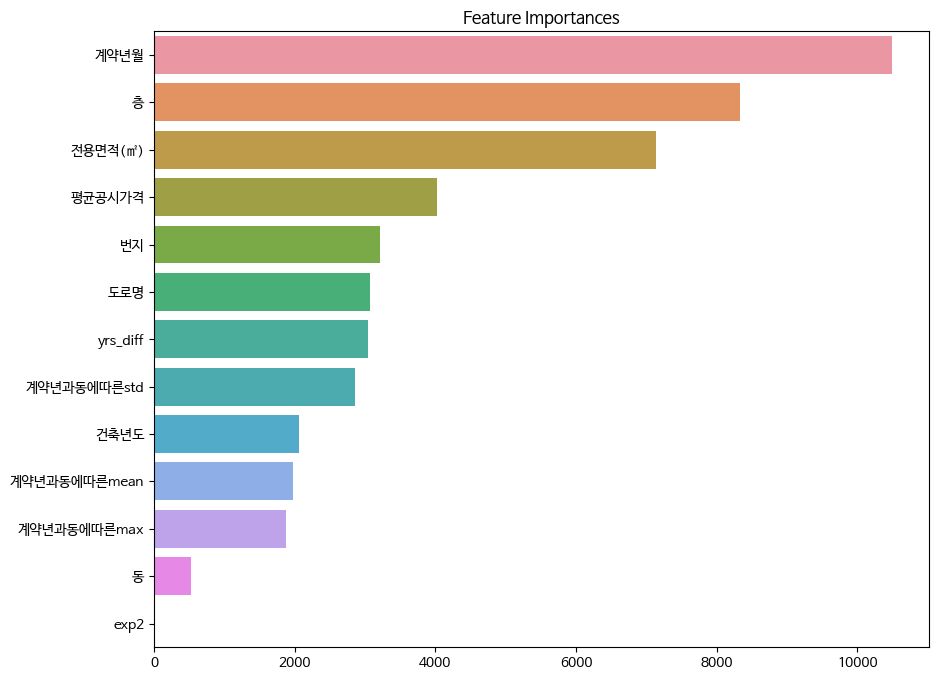

In [188]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm_exp.feature_importances_, index=list(X_train_exp.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [189]:
X_val_exp

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,exp2
288736,20,192.940,202103,1,2002,6986,144757.142857,311,284088.039234,297951.973684,1200000.0,19,2
230687,1806,165.446,202112,28,2009,5480,254242.023460,111,121181.327588,328087.039352,729000.0,12,2
296393,3694,141.381,201912,18,2004,6058,235662.708333,62,74236.647396,186429.715569,520000.0,15,2
393742,3594,243.230,201906,12,1979,5696,349963.690476,196,74401.842409,276701.507538,520000.0,40,2
651051,3594,157.360,201504,1,1979,5696,349963.690476,196,53375.111750,161282.860825,405000.0,36,2
504002,1806,194.515,201705,6,2009,5480,254242.023460,111,70938.271600,179022.393162,379500.0,8,2


In [191]:
dt_train.loc[230687]

시군구                               서울특별시 서초구 반포동
번지                                        20-43
본번                                         20.0
부번                                         43.0
아파트명                                       반포자이
전용면적(㎡)                                 165.446
계약년월                                     202112
계약일                                          21
층                                            28
건축년도                                       2009
도로명                                    신반포로 270
해제사유발생일                                     NaN
등기신청일자                                         
거래유형                                       중개거래
중개사소재지                                   서울 서초구
k-단지분류(아파트,주상복합등등)                          아파트
k-전화번호                                025334010
k-팩스번호                                025334075
단지소개기존clob                                638.0
k-세대타입(분양형태)                                 기타
k-관리방식                                  

In [460]:
dt_test['pred'] = preds_df
dt_test

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test,pred
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,1,193610.328186
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,...,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0,1,262267.698524
2,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,202307,28,15,1984,...,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0,1,275190.599043
3,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,133.4600,202308,10,14,1984,...,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0,1,250270.038583
4,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,104.4300,202308,18,6,1984,...,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0,1,203779.777291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.6500,202307,19,13,2014,...,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.106720,37.618870,2014-09-01 13:05:03.0,1,72026.872712
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.6200,202307,25,12,2014,...,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.106720,37.618870,2014-09-01 13:05:03.0,1,72211.536897
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.6500,202308,27,12,2014,...,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.106720,37.618870,2014-09-01 13:05:03.0,1,85608.149119
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.9400,202309,2,18,2014,...,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.106720,37.618870,2014-09-01 13:05:03.0,1,69462.562682


In [467]:
dt_test[(dt_test['pred']>=600000)&(dt_test['pred']<1000000)]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test,pred
255,서울특별시 강남구 도곡동,467,467.0,0.0,타워팰리스1,301.470,202307,31,55,2002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,652959.906679
521,서울특별시 강남구 압구정동,433,433.0,0.0,신현대11차,183.410,202307,11,9,1983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,616991.174748
5009,서울특별시 서초구 반포동,20-43,20.0,43.0,반포자이,244.628,202307,13,23,2009,...,6075.0,의무,2013-06-18 13:00:30.0,Y,N,127.013592,37.507538,2013-03-07 09:46:18.0,1,712164.781699
5013,서울특별시 서초구 반포동,20-43,20.0,43.0,반포자이,244.972,202308,2,23,2009,...,6075.0,의무,2013-06-18 13:00:30.0,Y,N,127.013592,37.507538,2013-03-07 09:46:18.0,1,753079.663142
5024,서울특별시 서초구 반포동,20-43,20.0,43.0,반포자이,244.543,202309,1,2,2009,...,6075.0,의무,2013-06-18 13:00:30.0,Y,N,127.013592,37.507538,2013-03-07 09:46:18.0,1,635036.888781
5025,서울특별시 서초구 반포동,20-43,20.0,43.0,반포자이,216.490,202309,4,17,2009,...,6075.0,의무,2013-06-18 13:00:30.0,Y,N,127.013592,37.507538,2013-03-07 09:46:18.0,1,615761.442775
5495,서울특별시 서초구 반포동,757,757.0,0.0,반포주공1단지,140.130,202307,26,4,1973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,607595.832054
5496,서울특별시 서초구 반포동,757,757.0,0.0,반포주공1단지,140.130,202308,2,3,1973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,602338.100454
6041,서울특별시 성동구 성수동1가,685-696,685.0,696.0,갤러리아포레,217.860,202308,11,36,2011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,681147.287075
6042,서울특별시 성동구 성수동1가,685-696,685.0,696.0,갤러리아포레,241.930,202308,22,27,2011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,688445.552860


In [470]:
wt= dt_train[dt_train['아파트명']=='신현대11차']
kkk= wt[wt['전용면적(㎡)']>=150]
kkk[kkk['계약년월']>=202201]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
203307,서울특별시 강남구 압구정동,433,433.0,0.0,신현대11차,183.41,202211,25,9,1983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,560000,0
203308,서울특별시 강남구 압구정동,433,433.0,0.0,신현대11차,183.41,202303,20,10,1983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,595000,0
203309,서울특별시 강남구 압구정동,433,433.0,0.0,신현대11차,183.41,202303,27,8,1983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600000,0
203311,서울특별시 강남구 압구정동,433,433.0,0.0,신현대11차,183.41,202306,26,7,1983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630000,0
224076,서울특별시 강남구 압구정동,433,433.0,0.0,신현대11차,183.41,202203,17,4,1983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,595000,0


In [448]:
pred_exp=gbm_exp.predict(X_val_exp)
pred_exp

array([255499.52722428, 520589.57697873, 239503.92767583, ...,
       418581.90268801, 270105.00902983, 284671.48690854])

In [449]:
val_index = X_val_exp.index
w_col = ['시군구','아파트명','전용면적(㎡)','층','계약년월','건축년도','target']
train_val_exp=dt_train.loc[val_index,w_col]

train_val_exp['pred']= pred_exp
train_val_exp['err'] = train_val_exp['target'] - train_val_exp['pred']
train_val_exp['abs_err'] = train_val_exp['err'].abs()

<Axes: ylabel='err'>

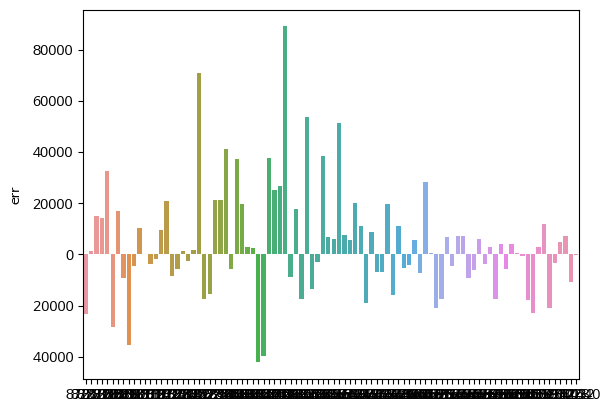

In [457]:
wt=train_val_exp[train_val_exp['아파트명']=='한남더힐']

sns.barplot(data=wt, x=wt.index, y='err')



In [451]:
pred0=gbm0.predict(X_val0)
pred0

array([ 74482.96025081, 124385.24944884, 118876.86185652, ...,
        39389.82130517, 127512.46490794,  25612.5018256 ])

In [452]:
val_index0 = X_val0.index
w_col = ['시군구','아파트명','전용면적(㎡)','층','계약년월','건축년도','target']
train_val0=dt_train.loc[val_index0,w_col]

train_val0['pred']= pred0
train_val0['err'] = train_val0['target'] - train_val0['pred']
train_val0['abs_err'] = train_val0['err'].abs()

In [454]:
train_val0[train_val0.err>=100000]

,시군구,아파트명,전용면적(㎡),층,계약년월,건축년도,target,pred,err,abs_err
447914,서울특별시 강남구 청담동,씨티1차102동,84.3300,8,201612,1992,399000,154760.903935,244239.096065,244239.096065
441076,서울특별시 강남구 개포동,개포주공1단지,61.5700,3,201705,1982,260000,151852.093127,108147.906873,108147.906873
201067,서울특별시 강남구 논현동,동양파라곤,180.0700,1,202305,2004,480000,347493.212801,132506.787199,132506.787199
749011,서울특별시 영등포구 여의도동,대우트럼프월드Ⅰ,244.9100,38,201503,2002,277500,169207.443184,108292.556816,108292.556816
520240,서울특별시 송파구 신천동,롯데캐슬골드,244.7500,36,201707,2005,399000,298554.502182,100445.497818,100445.497818
226981,서울특별시 광진구 자양동,더샵스타시티,177.9700,32,202205,2007,320000,218415.645470,101584.354530,101584.354530
447916,서울특별시 강남구 청담동,씨티1차102동,84.3300,5,201612,1992,258342,141891.052258,116450.947742,116450.947742
223562,서울특별시 강남구 개포동,디에이치아너힐즈,131.3226,8,202202,2019,590000,420078.448176,169921.551824,169921.551824


In [ ]:
pred0

In [459]:
dt_test[dt_test['아파트명']=='한남더힐']

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test
8281,서울특별시 용산구 한남동,810,810.0,0.0,한남더힐,59.686,202307,5,8,2011,...,32399.48,1717.0,의무,2017-09-22 17:33:57.0,Y,Y,127.009496,37.536978,2013-03-07 09:46:58.0,1
8282,서울특별시 용산구 한남동,810,810.0,0.0,한남더힐,208.478,202307,21,2,2011,...,32399.48,1717.0,의무,2017-09-22 17:33:57.0,Y,Y,127.009496,37.536978,2013-03-07 09:46:58.0,1
8283,서울특별시 용산구 한남동,810,810.0,0.0,한남더힐,59.686,202307,26,2,2011,...,32399.48,1717.0,의무,2017-09-22 17:33:57.0,Y,Y,127.009496,37.536978,2013-03-07 09:46:58.0,1
8284,서울특별시 용산구 한남동,810,810.0,0.0,한남더힐,59.700,202307,28,5,2011,...,32399.48,1717.0,의무,2017-09-22 17:33:57.0,Y,Y,127.009496,37.536978,2013-03-07 09:46:58.0,1
8285,서울특별시 용산구 한남동,810,810.0,0.0,한남더힐,240.305,202308,27,-1,2011,...,32399.48,1717.0,의무,2017-09-22 17:33:57.0,Y,Y,127.009496,37.536978,2013-03-07 09:46:58.0,1


In [471]:
X_test_exp

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,평균공시가격,동,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff,exp2,target
1119051,3696,177.255,202308,16,1999,6056,159453.061224,62,101022.387293,235754.117647,650000.0,24,2,2.853314e+05
1119052,3696,172.467,202308,16,1999,6056,159453.061224,62,101022.387293,235754.117647,650000.0,24,2,2.582047e+05
1119053,3696,138.657,202309,43,1999,6056,159453.061224,62,101022.387293,235754.117647,650000.0,24,2,2.690285e+05
1119067,5878,153.710,202307,8,1983,1771,141412.145749,62,101022.387293,235754.117647,650000.0,40,2,2.745105e+05
1119068,5878,153.710,202307,3,1983,1771,141412.145749,62,101022.387293,235754.117647,650000.0,40,2,2.654968e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127412,3078,237.520,202307,3,2019,8589,429625.000000,311,279436.203653,334323.529412,1100000.0,4,2,9.176340e+05
1127413,3078,239.670,202307,4,2019,8589,429625.000000,311,279436.203653,334323.529412,1100000.0,4,2,9.711803e+05
1127415,3258,268.670,202308,4,2020,6988,785864.705882,311,279436.203653,334323.529412,1100000.0,3,2,1.260003e+06
1127417,5641,203.760,202308,15,2002,4652,236636.885246,311,279436.203653,334323.529412,1100000.0,21,2,4.324610e+05
